In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoModel, BertTokenizerFast
import transformers

import seaborn as sns
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cpu")


In [26]:
df = pd.read_csv("../data/train/text_dataset_10.csv")
df = df.dropna(subset=['text'])

# df = df.sample(n=20000, random_state=42)  # You can change the random_state for different random samples
# Reset the index after sampling
# df = df.reset_index(drop=True)

# df = df.head(8000)

In [27]:
df

,text,location,interest
0,attempt hari tu act like smart deep tech entre...,Unknown,Technology
1,mosti cradle ni clueless whats going tech tal...,Unknown,Technology
2,hightech export country 942b hong kong 431b g...,Unknown,Technology
3,tbh many tech talent dont actually need focus...,Unknown,Technology
4,make 180000 tech consultant london grew extrem...,Unknown,Technology
...,...,...,...
24615,sport,Terengganu,Sports
24616,nobody want teman jogging,Terengganu,Sports
24617,footballtweet potter 1st,Terengganu,Sports
24618,smartwatch one better sport ea garmin amazfit ...,Terengganu,Sports


In [28]:
print(f"The dataset contains { df.interest.nunique() } unique categories")

The dataset contains 6 unique categories


In [29]:
# change to lower case
df['text'] = df['text'].apply(lambda text: str(text).lower())

In [30]:
#calculating the length of headlines and descriptions
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
df

,text,location,interest,text_len
0,attempt hari tu act like smart deep tech entre...,Unknown,Technology,28
1,mosti cradle ni clueless whats going tech tal...,Unknown,Technology,28
2,hightech export country 942b hong kong 431b g...,Unknown,Technology,30
3,tbh many tech talent dont actually need focus...,Unknown,Technology,31
4,make 180000 tech consultant london grew extrem...,Unknown,Technology,25
...,...,...,...,...
24615,sport,Terengganu,Sports,1
24616,nobody want teman jogging,Terengganu,Sports,4
24617,footballtweet potter 1st,Terengganu,Sports,3
24618,smartwatch one better sport ea garmin amazfit ...,Terengganu,Sports,9


C:\Users\Izzham Burhan\AppData\Local\Temp\ipykernel_21496\1503237925.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['text_len'])


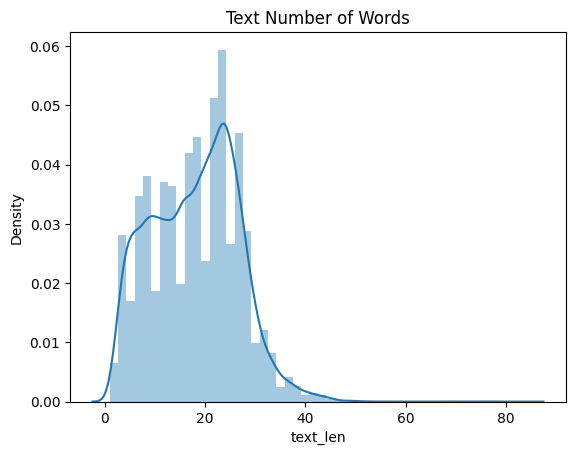

In [31]:
sns.distplot(df['text_len'])
plt.title('Text Number of Words')
plt.show()

In [32]:
# check class distribution
df['interest'].value_counts(normalize=True)

Entertainment    0.190699
Education        0.186474
Technology       0.169009
Sports           0.158570
FoodnDrink       0.149391
Politics         0.145857
Name: interest, dtype: float64

In [33]:
# split dataset into train and test sets
train_text, test_text, train_labels, test_labels = train_test_split(
    df['text'],
    df['interest'],
    random_state=2018,
    test_size=0.3,  # Adjust the test size as needed
    stratify=df['interest']
)

In [34]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')


<Axes: >

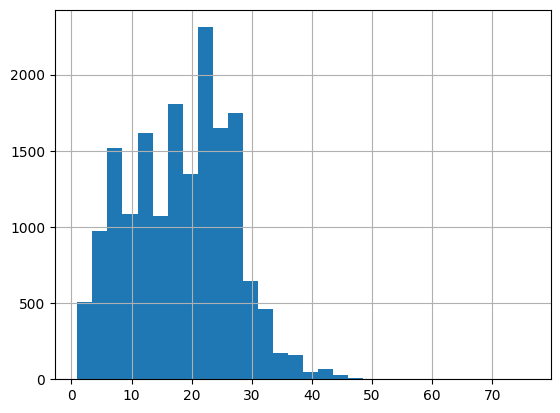

In [35]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins=30)

Tokenize & encode the sequences

In [36]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length=25,
    pad_to_max_length=True,
    truncation=True
)

c:\Users\Izzham Burhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


List to Tensors

In [37]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the labels for the training data
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_y = torch.tensor(train_labels_encoded, dtype=torch.long)

# Encode your labels using LabelEncoder for the test data
test_labels_encoded = label_encoder.transform(test_labels)
test_y = torch.tensor(test_labels_encoded, dtype=torch.long)


In [38]:
# wrap tensors for training data
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])

# wrap tensors for test data
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

Data Loader

In [39]:
# define a batch size
batch_size = 32

# wrap tensors for training data
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors for test data
test_data = TensorDataset(test_seq, test_mask, test_y)
# sampler for sampling the data during testing
test_sampler = SequentialSampler(test_data)
# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

Model Architecture

In [40]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [41]:
# Define your neural network architecture
class BERT_Arch(nn.Module):
    def __init__(self, bert, num_classes):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, num_classes)  
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [42]:
# Create the model
num_classes = 6 # Define the number of classes
model = BERT_Arch(bert, num_classes)

# push the model to GPU
model = model.to(device)

In [43]:
# optimizer from hugging face transformers
optimizer = transformers.AdamW(model.parameters(), lr=1e-5)

c:\Users\Izzham Burhan\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
from sklearn.utils.class_weight import compute_class_weight  
# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_encoded), y=train_labels_encoded)
weights = torch.tensor(class_weights, dtype=torch.float32)

# converting list of class weights to a tensor
weights = torch.tensor(class_weights, dtype=torch.float32)

print("Class Weights:", class_weights)


Class Weights: [0.89369425 0.8741124  1.11590262 1.14253514 1.05098183 0.98603959]


In [45]:
# define the loss function
cross_entropy = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

Fine - Tune

In [46]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask)

        loss = cross_entropy(preds, labels)
        total_loss = total_loss + loss.item()
        loss.backward()
        optimizer.step()
        preds = preds.detach().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [51]:
def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(test_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


def evaluate_with_embeddings():
    print("\nEvaluating with Embeddings...")
    model.eval()
    total_loss, total_preds, embeddings_list, text_list = 0, [], [], []

    for step, batch in enumerate(test_dataloader):
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            total_preds.append(preds)

            # Get text and embeddings
            text_list.extend(test_text[step * batch_size : (step + 1) * batch_size])  # Assuming test_text is a list of texts
            embeddings_list.extend(preds.detach().cpu().numpy())  # Assuming preds is the embeddings you want to extract

    avg_loss = total_loss / len(test_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds, text_list, embeddings_list

In [52]:
# set initial loss to infinite
best_valid_loss = float('inf')

train_losses = []
valid_losses = []

# empty lists to store training and validation loss of each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    # train model
    train_loss, _ = train()
    
    # evaluate model
    valid_loss, _ = evaluate()
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 1
Batch    50 of   539.
Batch   100 of   539.
Batch   150 of   539.
Batch   200 of   539.
Batch   250 of   539.
Batch   300 of   539.
Batch   350 of   539.
Batch   400 of   539.
Batch   450 of   539.
Batch   500 of   539.

Evaluating...
  Batch    50  of    231.
  Batch   100  of    231.
  Batch   150  of    231.
  Batch   200  of    231.

Training Loss: 1.703
Validation Loss: 1.670


In [53]:
# load weights of the best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [55]:
# # get predictions for test data
# with torch.no_grad():
#     preds = model(test_seq.to(device), test_mask.to(device))
#     preds = preds.detach().cpu().numpy()

with torch.no_grad():
    preds, _, text_list, embeddings_list = evaluate_with_embeddings()

# Assuming 'interest' is the column with actual interests in the original DataFrame
actual_interests = test_labels.tolist()

# Create a DataFrame with actual interests, predicted interests, text, and embeddings
results_df = pd.DataFrame({'Actual_Interest': actual_interests, 'Predicted_Interest': preds, 'Text': text_list, 'Embeddings': embeddings_list})

# Add the original test dataset to the DataFrame if needed
test_data_df = pd.DataFrame({'Text': test_text, 'Actual_Interest': actual_interests})
results_df = pd.concat([results_df, test_data_df], axis=1)


Evaluating with Embeddings...
  Batch    50  of    231.
  Batch   100  of    231.
  Batch   150  of    231.
  Batch   200  of    231.


In [56]:
results_df

,Actual_Interest,Predicted_Interest,Text,Embeddings,Text,Actual_Interest
0,Education,1.670305,fadhlinasiddiq starting get feeling main focus...,"[-1.8351346, -1.7061007, -1.9038793, -1.702289...",NaN,NaN
1,FoodnDrink,1.670305,20 teh tarik pulled tea hot milk tea like k...,"[-1.8531061, -1.8432728, -1.7047919, -1.720423...",mosti cradle ni clueless whats going tech tal...,Technology
2,Politics,1.670305,melgohcna imagine dont chinese ever recogniz...,"[-1.787531, -1.801147, -1.8092394, -1.6822101,...",NaN,NaN
3,Sports,1.670305,buletintv3 think football team worse think kel...,"[-1.7959303, -1.8106498, -1.9381902, -1.616795...",tbh many tech talent dont actually need focus...,Technology
4,Sports,1.670305,2 world chionship gold medal badminton cheat c...,"[-1.7903001, -1.791293, -2.1187992, -1.8503754...",make 180000 tech consultant london grew extrem...,Technology
...,...,...,...,...,...,...
18297,NaN,NaN,NaN,NaN,love tues n thurs go school noon japanese clas...,Education
18912,NaN,NaN,NaN,NaN,abilsuhaimi netflix night school comedy relax ...,Education
21784,NaN,NaN,NaN,NaN,kinda productive day went hiking morning laun...,Sports
7533,NaN,NaN,NaN,NaN,elonmusk rothbard1776 stillgray government edu...,Politics


In [58]:
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [59]:
# model's performance
preds = np.argmax(preds, axis=1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.72      0.10      0.17      1377
           1       0.49      0.54      0.51      1409
           2       0.55      0.41      0.47      1104
           3       0.38      0.81      0.51      1077
           4       0.54      0.42      0.47      1171
           5       0.44      0.57      0.50      1248

    accuracy                           0.46      7386
   macro avg       0.52      0.47      0.44      7386
weighted avg       0.52      0.46      0.43      7386



In [ ]:
# # Create a DataFrame to store the results
# results_df = pd.DataFrame(columns=['Index', 'Text', 'Actual Interest', 'Predicted Interest'])

In [ ]:
# # Populate the results DataFrame
# results_df['Index'] = range(len(test_y))
# results_df['Text'] = test_text.tolist()
# results_df['Actual Interest'] = label_encoder.inverse_transform(test_y.numpy())
# results_df['Predicted Interest'] = label_encoder.inverse_transform(preds)

# # Display the results DataFrame
# results_df

,Index,Text,Actual Interest,Predicted Interest
0,0,fadhlinasiddiq starting get feeling main focus...,Education,Entertainment
1,1,20 teh tarik pulled tea hot milk tea like k...,FoodnDrink,FoodnDrink
2,2,melgohcna imagine dont chinese ever recogniz...,Politics,Politics
3,3,buletintv3 think football team worse think kel...,Sports,Politics
4,4,2 world chionship gold medal badminton cheat c...,Sports,Sports
...,...,...,...,...
7381,7381,abilsuhaimi netflix night school comedy relax ...,Education,Entertainment
7382,7382,familiar linux system r programming requiremen...,Technology,Technology
7383,7383,kinda productive day went hiking morning laun...,Sports,FoodnDrink
7384,7384,elonmusk rothbard1776 stillgray government edu...,Politics,Education


In [ ]:
# # Save the results to a CSV file if needed
# results_df.to_csv('../data/compare/test_results_bert.csv', index=False)